In [1]:
%run ./rob_setup_notebook.ipynb

['/home/rlees/Documents/Code/suite2p/suite2p']
QNAP_path: /home/rlees/mnt/qnap 
QNAP_data_path /home/rlees/mnt/qnap/Data 
Pickle folder: /home/rlees/mnt/qnap/pkl_files 
Master pickle: /home/rlees/mnt/qnap/master_pkl/master_obj.pkl 
Figure save path: /home/rlees/mnt/qnap/Analysis/Plots 
STA movie save path: /home/rlees/mnt/qnap/Analysis/STA_movies 
S2 borders path: /home/rlees/mnt/qnap/Analysis/S2_borders


### Make STA movies

In [ ]:
with open(master_path, 'rb') as f:
    master_obj = pickle.load(f)

pkl_list = [
#             '2019-06-11_J048.pkl',
#             '2019-06-13_J052.pkl',
#             '2019-06-25_RL048.pkl',
#             '2019-07-15_RL052.pkl',
#             '2019-08-14_J058.pkl',
#             '2019-08-14_J059.pkl',
#             '2019-08-15_RL055.pkl',
#             '2019-11-14_J061.pkl',
#             '2019-11-14_J063.pkl',
#             '2019-11-15_J064.pkl',
#             '2019-11-18_J065.pkl',
#             '2020-02-27_RL075.pkl',
#             '2020-03-03_RL074.pkl',
#             '2020-03-05_RL070.pkl',
#             '2020-03-05_RL072.pkl',
#             '2020-03-12_RL070.pkl',
#             '2020-03-16_RL074.pkl',
#             '2020-03-19_RL075.pkl',
            '2020-03-20_RL080.pkl'
           ]

for i,pkl in enumerate(pkl_list):
    pkl_list[i] = os.path.join(qnap_path, 'pkl_files', pkl)
    
master_obj.staMovie(stam_save_path, pkl_list)

master_obj.plotDrift(pkl_list, legend=True)
plt.savefig(os.path.join(fig_save_path, 'fluorescence_drift_time.svg'));

### Plot fluorescence across all concatenated t-series frames

2019-06-11_J048.pkl
2019-06-13_J052.pkl
2019-06-25_RL048.pkl
2019-07-15_RL052.pkl
2019-08-14_J058.pkl
2019-08-14_J059.pkl
2019-08-15_RL055.pkl
2019-11-14_J061.pkl
2019-11-14_J063.pkl
2019-11-15_J064.pkl
2019-11-18_J065.pkl
2020-02-27_RL075.pkl
2020-03-03_RL074.pkl
2020-03-05_RL070.pkl
2020-03-05_RL072.pkl
2020-03-12_RL070.pkl
2020-03-16_RL074.pkl
2020-03-19_RL075.pkl
2020-03-20_RL080.pkl


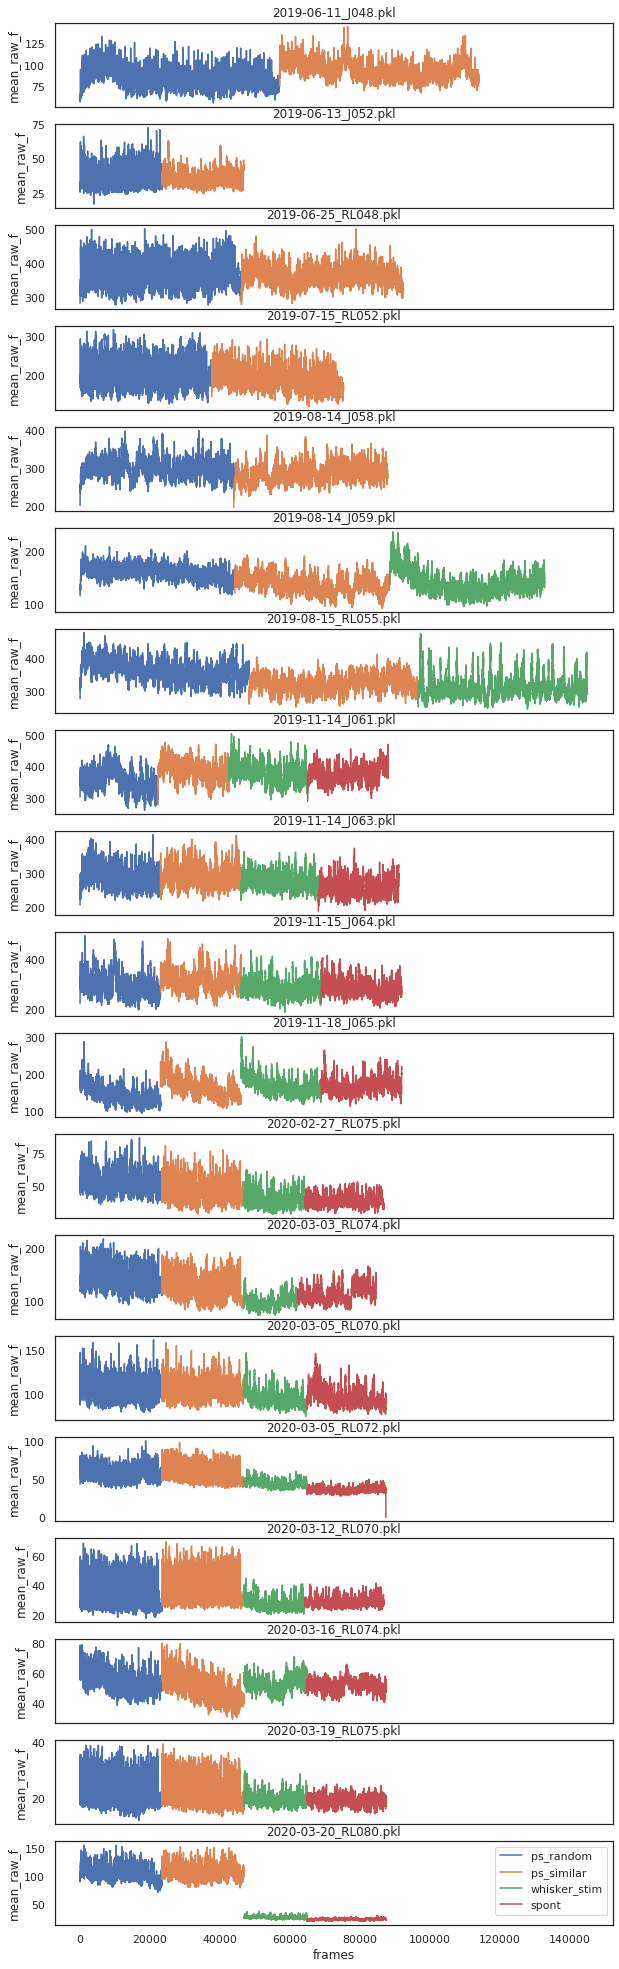

In [18]:
pkl_files = os.listdir(pkl_folder)

fig, ax = plt.subplots(nrows=len(pkl_files), ncols=1, figsize=(10,35), sharex=True)

for i,pkl in enumerate(pkl_files):
    if '.pkl' in pkl:
        
        print(pkl)
        
        pkl_path = os.path.join(pkl_folder, pkl)

        with open(pkl_path, 'rb') as f:
            exp_obj = pickle.load(f)
        
        sub_obj = exp_obj.photostim_r
        
        mean_f = np.mean(sub_obj.raw[0], axis=0)
        
        count = 0
        
        for frames in exp_obj.frame_list:
            x = range(count,count+frames)
            ax[i].plot(x, mean_f[x]);
            ax[i].set_title(pkl)
            ax[i].set_ylabel('mean_raw_f')
            
            count += frames

plt.xlabel('frames')
labels = ['ps_random', 'ps_similar', 'whisker_stim', 'spont']
plt.legend(labels)
plt.savefig(os.path.join(fig_save_path, 'cell_fluorescence_time.svg'));

### Make downsampled stack of first 1000 and last 1000 frames of each experiment for all sessions

In [4]:
pkl_files = os.listdir(pkl_folder)

for i,pkl in enumerate(pkl_files):
    if '.pkl' in pkl:
        
        print(pkl)
        
        pkl_path = os.path.join(pkl_folder, pkl)

        with open(pkl_path, 'rb') as f:
            exp_obj = pickle.load(f)
            
        pkl_list = [exp_obj.photostim_r, exp_obj.photostim_s]

        if exp_obj.spont.n_frames > 0:
            pkl_list.append(exp_obj.spont)

        if exp_obj.whisker_stim.n_frames > 0:
            pkl_list.append(exp_obj.whisker_stim)
        
        for sub_obj in pkl_list:
            
            tiff_path = sub_obj.tiff_path
            
            file_list = os.listdir(tiff_path)
            for file in file_list:
                if '.tif' in file:
                    tiff_file = os.path.join(tiff_path, file)
  
            total_frames = range(0,sub_obj.n_frames) #get the range of frames for this experiment
            start_frames = total_frames[30:1000] # get 970 frames after start
            end_frames = total_frames[-1000:-30] # get 970 frames before end
            
            stack_start = tf.imread(tiff_file, key=start_frames)
            stack_end = tf.imread(tiff_file, key=end_frames)
            
            mean_start = np.mean(stack_start, axis=0)
            mean_end = np.mean(stack_end, axis=0)
            
            save_path = os.path.join(qnap_path, 'Analysis', 'Drift_check', 'Raw', tiff_path.split('/')[-1])
            
            tf.imsave(save_path + '_mean_start.tif', mean_start.astype('int16'))
            tf.imsave(save_path + '_mean_end.tif', mean_end.astype('int16'))

2020-03-03_RL074.pkl


### Plot frame fluorescence over time for each experiment in all sessions

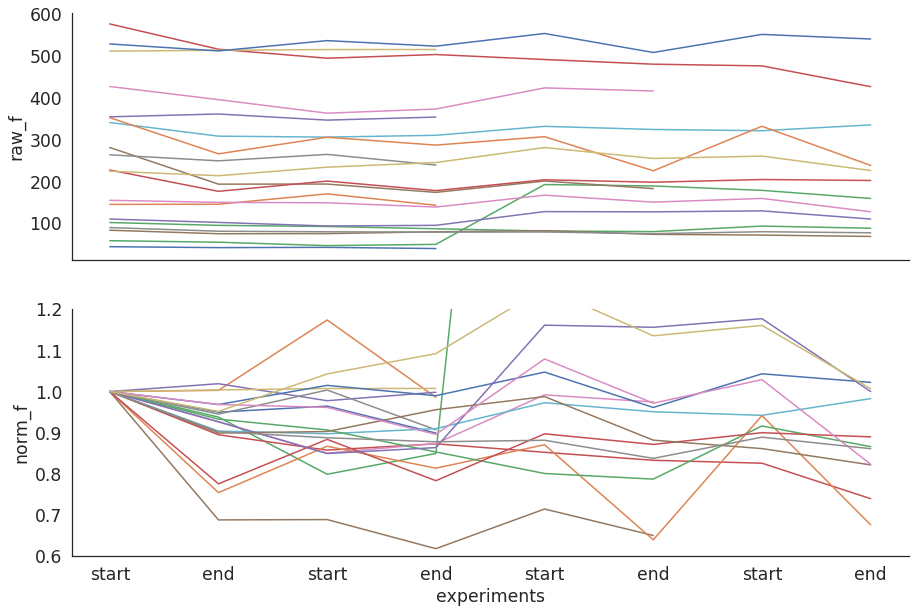

In [2]:
data_folder = os.path.join(qnap_path, 'Analysis', 'Drift_check', 'Stacks')

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,10), sharex=True)
labels = []

for _, _, files in os.walk(data_folder):
    for file in files:
        file_path = os.path.join(data_folder,file)

        tiff = tf.imread(file_path)

        raw_f_drift = np.mean(tiff, axis=(1,2)) - (2**16/2)
        norm_f_drift = raw_f_drift/raw_f_drift[0]

        ax[0].plot(raw_f_drift)
        ax[1].plot(norm_f_drift)
        labels.append(file)
        
plt.xlabel('experiments');
plt.xticks(range(0,8), np.tile(np.array(['start','end']), 4));
ax[0].set_ylabel('raw_f');
ax[1].set_ylabel('norm_f');
ax[1].set_ylim([0.6, 1.2]);

# plt.legend(labels);
# plt.savefig(os.path.join(fig_save_path, 'frame_fluorescence_time.svg'));